# 「プチ」勉強会 20230729
* 改めてタイタニックをやってみた。入門問題と言われているが、実はそうでもない難しさがある。
* まず、データ数が少ない。やたら多いのも大変だか基本的に計算は機械がやってくれることなのでデータは多いに越したことはない。<br>
少ないとブレが大きく的を絞りにくくなる。バリデーション結果が定まりにくい。
* カラムが少ない。初心者向けに処理が煩雑にならないようしてあるのかもしれないが、EDAの手がかりを見つけるのが難しい。<br>
それでもタイタニックは歴史的事実でさまざまに研究されていることがらなので、周辺知識からアプローチする手段はある。
* 本家のKaggleがaccuracyなのに対してこの課題だけaucにしてある趣旨は不明。この問題は確率分布の連続値ではなくデジタルな解答を求める方が趣旨に合うと思う。<br>
（kaggleのTitanicは連続値では評価できないaccuracyを指定している）
* 結果はまずまずだと思う。kaggleなら上位1～2%には入っている数字。(accuracy0.8を超えるのが壁と言われている)

## 今回取り組んでみたこと

1. できるだけEDAの基本からきちんと進めて結果に繋げられるよう丁寧さに留意した。
```
   ・性格的にざっくりやりがちなので、丁寧にやるよう心がけた。（それでもざっくりはしているが）
   ・なお、周辺知識を探索しているとテーマがテーマだけに情報は多く、「完全な正解」も入手できることが分かった
   ・でもここでそれを使っては意味がないので、当然ながら完全に所与のデータから積上げて得られるEDAだけで構築した
   ・周辺情報はドメイン知識とも言われることだが、ここで学んでいるのは機械学習とドメイン知識の相互作用、相乗効果だろう
```
2. いくつか、これまでにやったことがないアプローチを試した。
```
   ・欠損値補完に機械学習を用いた。これは使えると思う
   ・グラフ描画にhistplotのほか、countplotを使った。二値分類をやるのに向いていると思う
   ・各々のデータが独立ではない（横のつながりがある）ため、項目により訓練データとテストデータを統合して分析した
   ・nameやcabin、tiketといった横のつながりを示唆する特徴量は消されているが、それでも「fareが同一のパターン」が確認できるとわかった
   ・なぜembarkedが'S'（Southampton）の乗客ばかり死亡しているのか、なぜ、女性の生存率がこれほどまでに高いのかといったことは周辺知識の探索がなければ分からない
     それ自体は処理やスコアに直接関係しないが、特徴量エンジニアリングを行う上で、それが本源的な特徴なのかどうかを判断する基準になる
   ・ちなみに、応用の方で取り組み中のクラスタリングで、前処理に行う多様体(manifold)アルゴリズムによる次元縮約がスコア向上のテクニックのひとつになることがわかった
   　但し、ここで試みたEDAやエンコーディングとは一部やり方が違ってくるので別のプチのテーマにする
```

# タイタニック号の乗客の生存有無を予想しよう

In [1]:

# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression as LR            # ロジスティック回帰
from sklearn import tree                                             # 決定木
from sklearn import ensemble                                         # ランダムフォレスト

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score # AUC、accuracy
import warnings
warnings.simplefilter('ignore')

sns.set(style='white')
import japanize_matplotlib


In [2]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\Titanic\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\Titanic\\test.csv')

In [3]:
# 要素毎の生存率を表にする関数を定義

def nin(*args, data=df, target='survived'):
    arglist = list(args)
    arglist.append(target)
    a = data[data[target]==1][arglist].groupby(arglist[0:-1])[target].count()
    b = data[arglist].groupby(arglist[0:-1])[target].count()
    c = a / b
    a.name = f'{target}(a)'
    b.name = 'total(b)'
    c.name = 'a/b'
    d = pd.concat([a, b, c], axis=1)
    return d

# 都度、groupbyで集計するのが煩雑なので4月の最初の課題で作成したツール
# 今回も大活躍

## データ概観

In [4]:
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値                     ： train   test
# age                        :  133     44
# embarked                   :    2      0

# 訓練データの数が668しかないので欠損値の処理は丁寧に行う必要がある
# 性別(sex)と乗船地(embarked)がobjectなので別途処理が必要
# ageとfareは連続した数値なのでそのまま扱うか閾値を見つけて切り分けるか判断が必要
# その他の列はuniquな要素数も全て一桁で少ないので特別な考慮は不要だがここも必要に応じて考える
# 特徴量は闇雲に作るのではなく、情報の消失に留意しつつ、ノイズを消しつつ、特徴が際立つよう工夫する

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        668 non-null    int64  
 1   survived  668 non-null    int64  
 2   pclass    668 non-null    int64  
 3   sex       668 non-null    object 
 4   age       535 non-null    float64
 5   sibsp     668 non-null    int64  
 6   parch     668 non-null    int64  
 7   fare      668 non-null    float64
 8   embarked  666 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 47.1+ KB


None

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,3,1,3,female,26.0,0,0,7.9250,S
2,4,1,1,female,35.0,1,0,53.1000,S
3,5,0,3,male,35.0,0,0,8.0500,S
4,7,0,1,male,54.0,0,0,51.8625,S


,ID,survived,pclass,age,sibsp,parch,fare
count,668.000000,668.000000,668.000000,535.000000,668.000000,668.000000,668.000000
mean,445.911677,0.386228,2.305389,29.900000,0.534431,0.392216,32.373621
std,259.966783,0.487249,0.837377,14.487993,1.161739,0.822509,50.632021
min,1.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,216.250000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,445.500000,0.000000,3.000000,29.000000,0.000000,0.000000,14.500000
75%,674.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,sex,embarked
count,668,666
unique,2,3
top,male,S
freq,437,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        223 non-null    int64  
 1   pclass    223 non-null    int64  
 2   sex       223 non-null    object 
 3   age       179 non-null    float64
 4   sibsp     223 non-null    int64  
 5   parch     223 non-null    int64  
 6   fare      223 non-null    float64
 7   embarked  223 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 14.1+ KB


None

,ID,pclass,sex,age,sibsp,parch,fare,embarked
0,2,1,female,38.0,1,0,71.2833,C
1,6,3,male,NaN,0,0,8.4583,Q
2,9,3,female,27.0,0,2,11.1333,S
3,11,3,female,4.0,1,1,16.7000,S
4,15,3,female,14.0,0,0,7.8542,S


,ID,pclass,age,sibsp,parch,fare
count,223.000000,223.000000,179.000000,223.000000,223.000000,223.000000
mean,446.264574,2.318386,29.098715,0.488789,0.349776,31.696729
std,249.935932,0.833949,14.665346,0.904747,0.755513,46.875335
min,2.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,249.000000,2.000000,19.000000,0.000000,0.000000,7.895800
50%,448.000000,3.000000,26.000000,0.000000,0.000000,13.000000
75%,655.500000,3.000000,38.000000,1.000000,0.000000,30.000000
max,891.000000,3.000000,70.000000,5.000000,5.000000,263.000000


,sex,embarked
count,223,223
unique,2,3
top,male,S
freq,140,154


## EDA（データ探索）

```
ID              :インデックスとして使用
survived        :生還結果（1=生還, 0=死亡）
pclass          :客室のクラス（1,2,3の順に高級クラス）
sex             :性別
age             :年齢
sibsp           :乗船していた兄弟、配偶者の数
parch           :乗船していた両親、子供の数
fare            :運賃
embarked        :乗船した港（S, C, Q）
```

## EDA(データ探索)

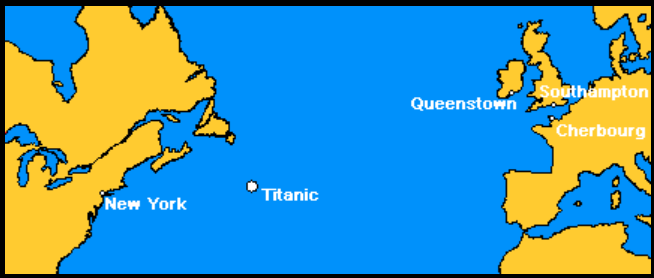

,survived
survived,
0,410
1,258


生存確率は、 38.62%


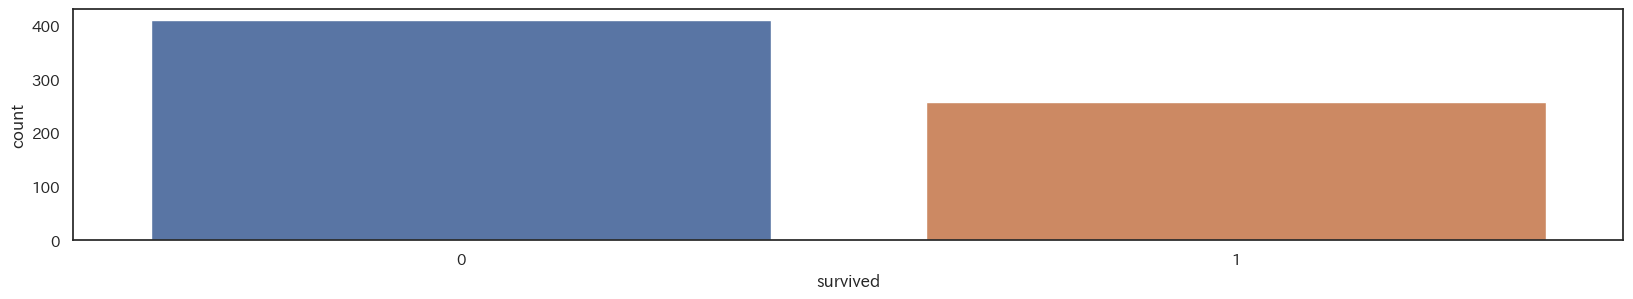

In [5]:
# survived(目的変数)

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='survived', ax=ax)

display(df.groupby('survived')[['survived']].count())
print(f'生存確率は、{258/(410+258): 0.2%}')

# kaggleの同名のコンペがあり、この課題はそのデータを一部変更したものであることがわかる
# kaggleのデータセットにはある、name(titleと氏名), cabin(部屋番号)やticket（チケット番号）などが省かれているが、解説動画ではnameが分類に利用されている
# これらの情報から、人々の生存のための協力関係などが推定されるが、ここではその情報はないのであるものを使って出来る限りのことをやる方針
# wikipediaの情報も有益
#   旅客定員	1等旅客  833人
#              2等旅客  614人
#              3等旅客 1006人
#   乗組員	            899人
#   * 三等船室は船の前と後ろに分かれており、独身男性と夫婦には船首部、独身女性と家族には船尾部が当てがわれた
#     これはホワイトスターライン社のピューリタン的思想に基づくもので、独身男性と独身女性を遠く離す意図からそうなっていた
#   * 沈没が差し迫ったタイタニックでは、左舷はライトラー二等航海士が、右舷はマードック次席一等航海士が救命ボートへの移乗を指揮し、
#     ライトラーは一等船客の「女性と子供を優先する」ことを遵守したが、マードックは比較的男性にも寛大な対応をした
#   ⇒ つまり、宿泊する部屋の位置関係が生死に大きく影響したということ
#
# 周辺情報へのアプローチで、なぜこのような分布になっているかの理由が分かり、特徴量への理解が深まる


pclass,1,2,3
survived(a),100.000000,68.000000,90.000000
total(b),163.000000,138.000000,367.000000
a/b,0.613497,0.492754,0.245232


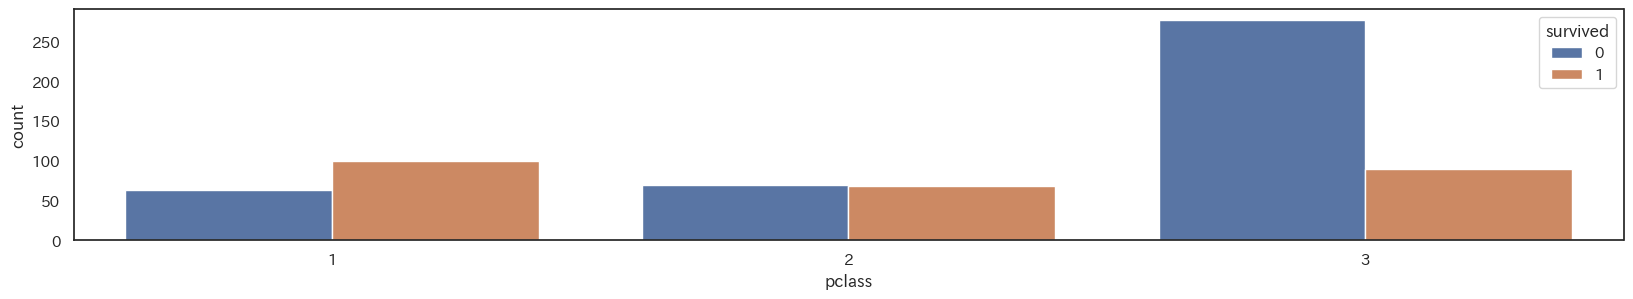

In [6]:
# pclass

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='pclass', hue='survived', ax=ax)

display(nin('pclass').T)

# KaggleのHPの解説にpclassの1st,2nd,3rdは、1がUpper,2がMiddle, 3がLowerとある
# これは単にクラスの上下というだけでなく、関連設備とともに物理的に区分けされていることが重要
# 初期の避難で女性や子供、1等客が優先されたほか、1等客は救命ボートへのアクセスが良かったことも見逃せない
# 3等の乗客の多くが死亡しており、1等と3等では生存率が2.5倍も違う（乗組員も9割死亡したと言われており、ここには乗組員も含まれているはず）
# pclassの特徴量は要素の数も3と少なく各々に一定量のデータがあるので、他の特徴量との組み合わせを考慮することが可能

sex,female,male
survived(a),174.000000,84.00000
total(b),231.000000,437.00000
a/b,0.753247,0.19222


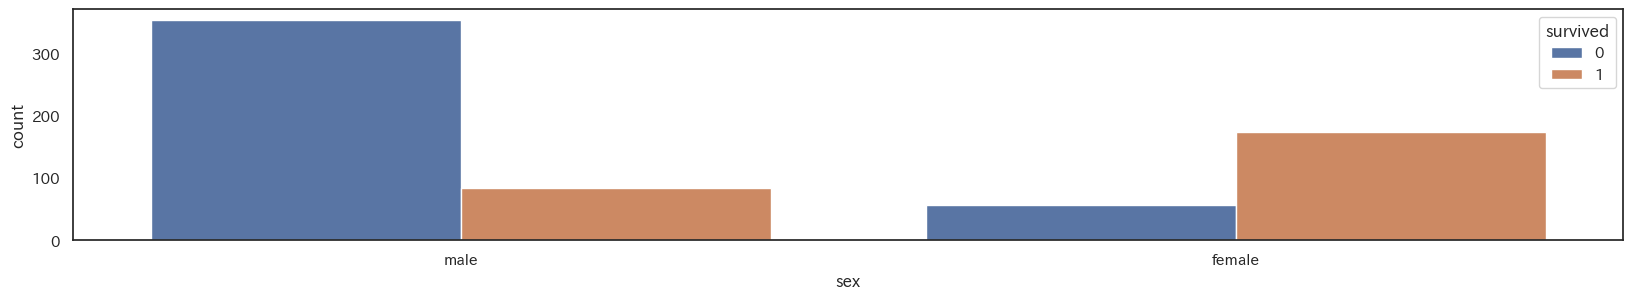

In [7]:
# sex

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='sex', hue='survived', ax=ax)

display(nin('sex').T)

# 初期の避難では女性や子供が優先して救命ボートに乗せられたと言われており、女性の生存率が著しく高い
# この特徴量もこのままではなく他の特徴量との関係を探索する余地がある

age_5s,～5,～10,～15,～20,～25,～30,～35,～40,～45,～50,～55,～60,～65,～70,～75,～80
survived(a),23.000000,5.000000,8.000000,25.000000,28.000000,35.000000,31.000000,23.000000,13.000000,12.0,8.0,5.000000,2.000000,0.0,0.0,1.0
total(b),35.000000,13.000000,11.000000,70.000000,86.000000,86.000000,65.000000,56.000000,37.000000,30.0,16.0,14.000000,9.000000,2.0,4.0,1.0
a/b,0.657143,0.384615,0.727273,0.357143,0.325581,0.406977,0.476923,0.410714,0.351351,0.4,0.5,0.357143,0.222222,0.0,0.0,1.0


age_3d,～5,～15,15～
survived(a),23.000000,13.000000,183.000000
total(b),35.000000,24.000000,476.000000
a/b,0.657143,0.541667,0.384454


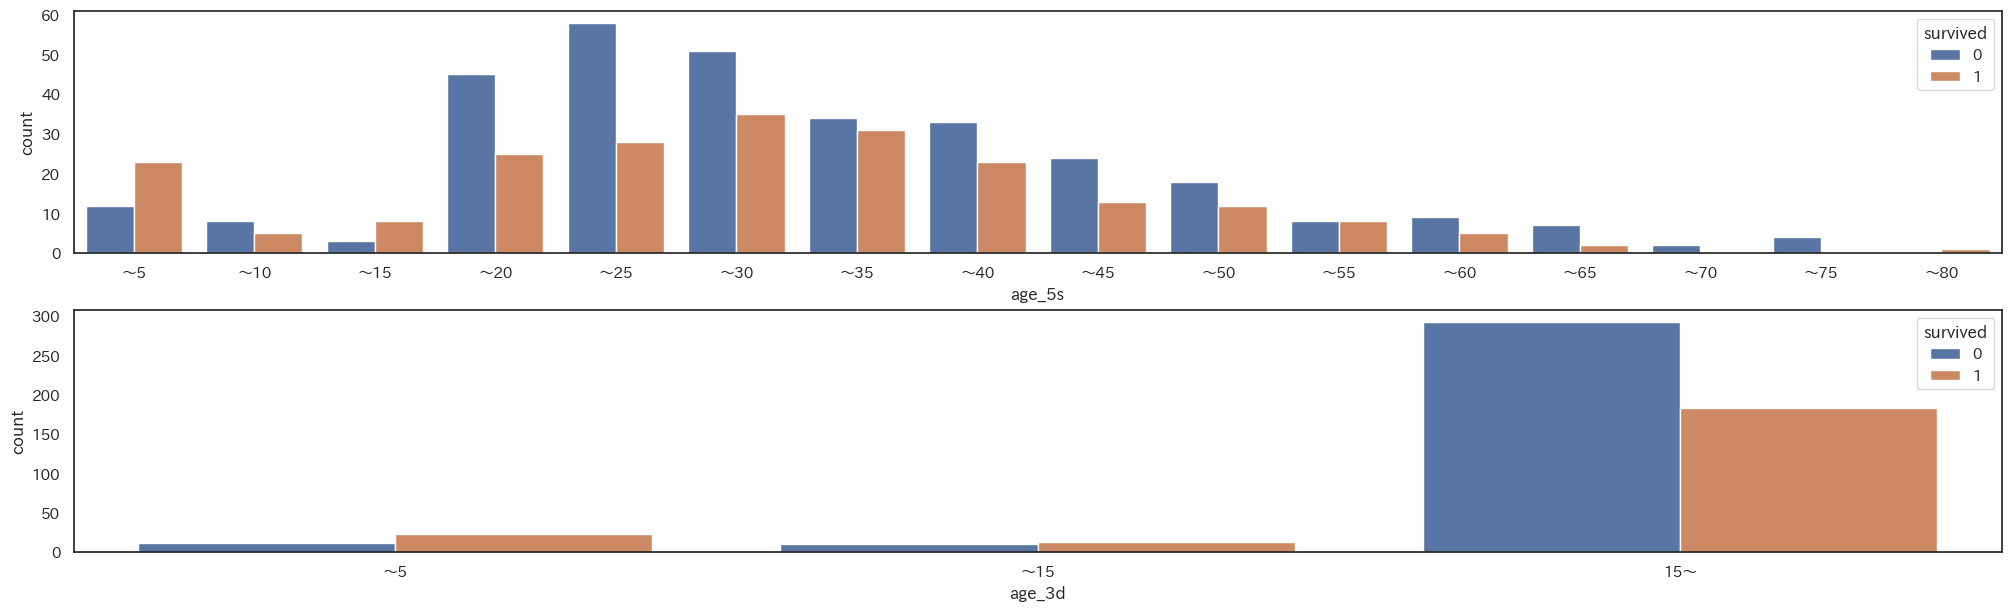

In [8]:
# age

df['age_5s'] = pd.cut(df['age'], [i for i in range(0, 81, 5)], labels=['～'+ str(i) for i in range(5, 81, 5)])
df['age_3d'] = pd.cut(df['age'], [0, 5, 15, 80], labels=['～5', '～15', '15～' ])
 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='age_5s', hue='survived', ax=ax1)
sns.countplot(data=df, x='age_3d', hue='survived', ax=ax2)
display(nin('age_5s', data=df).T)
display(nin('age_3d', data=df).T)

# 可視化にあたり、視認性を高めるために5歳刻みで纏めた
# 初期の避難で女性と子供が優先されたことから（5歳から10歳は平均の数値だが）5歳以下の乳幼児を筆頭に15歳以下の生存率が高いことが見て取れる


sibsp,0,1,2,3,4,5,8
survived(a),161.000000,83.000000,9.000000,2.0,3.000000,0.0,0.0
total(b),458.000000,153.000000,23.000000,10.0,13.000000,4.0,7.0
a/b,0.351528,0.542484,0.391304,0.2,0.230769,0.0,0.0


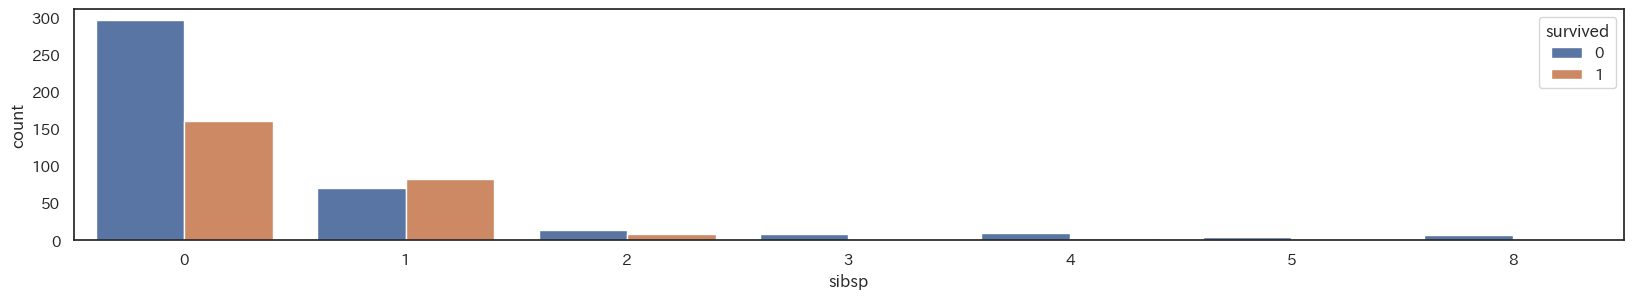

In [9]:
# sibsp

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='sibsp', hue='survived', ax=ax)

display(nin('sibsp').T.fillna(0))

# 次のparch同様0の生存率がやや低く、1以上はサンプル数が少ないところを除けば総じて生存率が高い

parch,0,1,2,3,5,4,6
survived(a),176.00000,47.000000,31.000000,3.0,1.00,NaN,NaN
total(b),507.00000,85.000000,64.000000,5.0,4.00,2.0,1.0
a/b,0.34714,0.552941,0.484375,0.6,0.25,NaN,NaN


,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_5s,age_3d
578,778,1,3,female,5.0,0,0,12.475,S,～5,～5


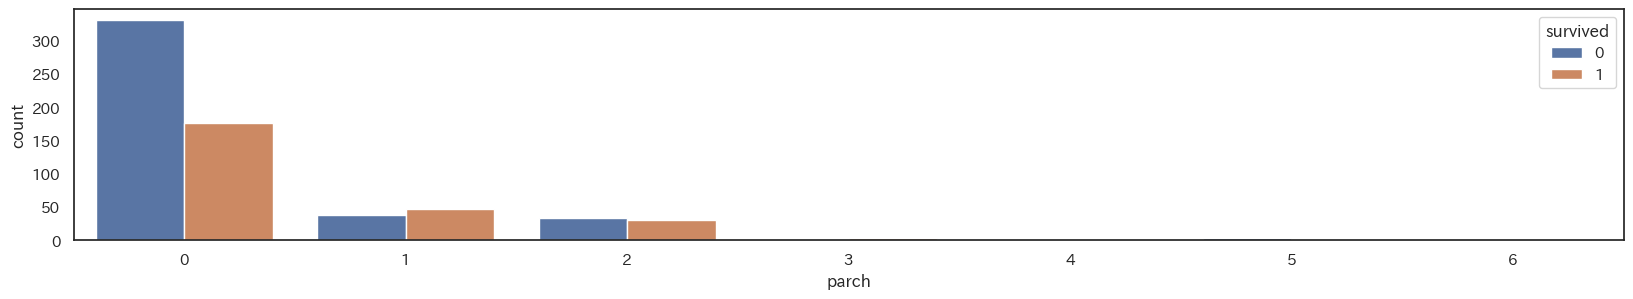

In [10]:
# parch

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='parch', hue='survived', ax=ax)

display(nin('parch').T)
display(df[(df['age']<=5)&(df['parch']==0)])

# sibsp同様の傾向であり、つまり、近しいもの同士で乗船しているグループと単独で乗船しているグループに生存率の差があるということがわかる
# おそらくは危機に際しての協力関係がプラスに寄与するだろうし、そもそも同部屋である可能性が高い
# なお、KaggleのHPの解説に、Some children travelled only with a nanny, therefore parch=0 for them.とある
# これは、両親や子供の数を示すparghが0の子供はnanny（保母）と乗船しているという意味だが最初見たときはただの間違いだと思った

fare_10s,～0,～10,～20,～30,～40,～50,～60,～70,～80,～90,～100,～300,～600
survived(a),1.0,53.000000,57.000000,45.000000,18.000000,4.000000,21.000000,5.000000,14.000000,11.000000,3.0,23.000000,3.0
total(b),10.0,236.000000,137.000000,105.000000,42.000000,15.000000,31.000000,15.000000,24.000000,12.000000,3.0,35.000000,3.0
a/b,0.1,0.224576,0.416058,0.428571,0.428571,0.266667,0.677419,0.333333,0.583333,0.916667,1.0,0.657143,1.0


fare_3d,～10,～50,～600
survived(a),54.000000,124.000000,80.000000
total(b),246.000000,299.000000,123.000000
a/b,0.219512,0.414716,0.650407


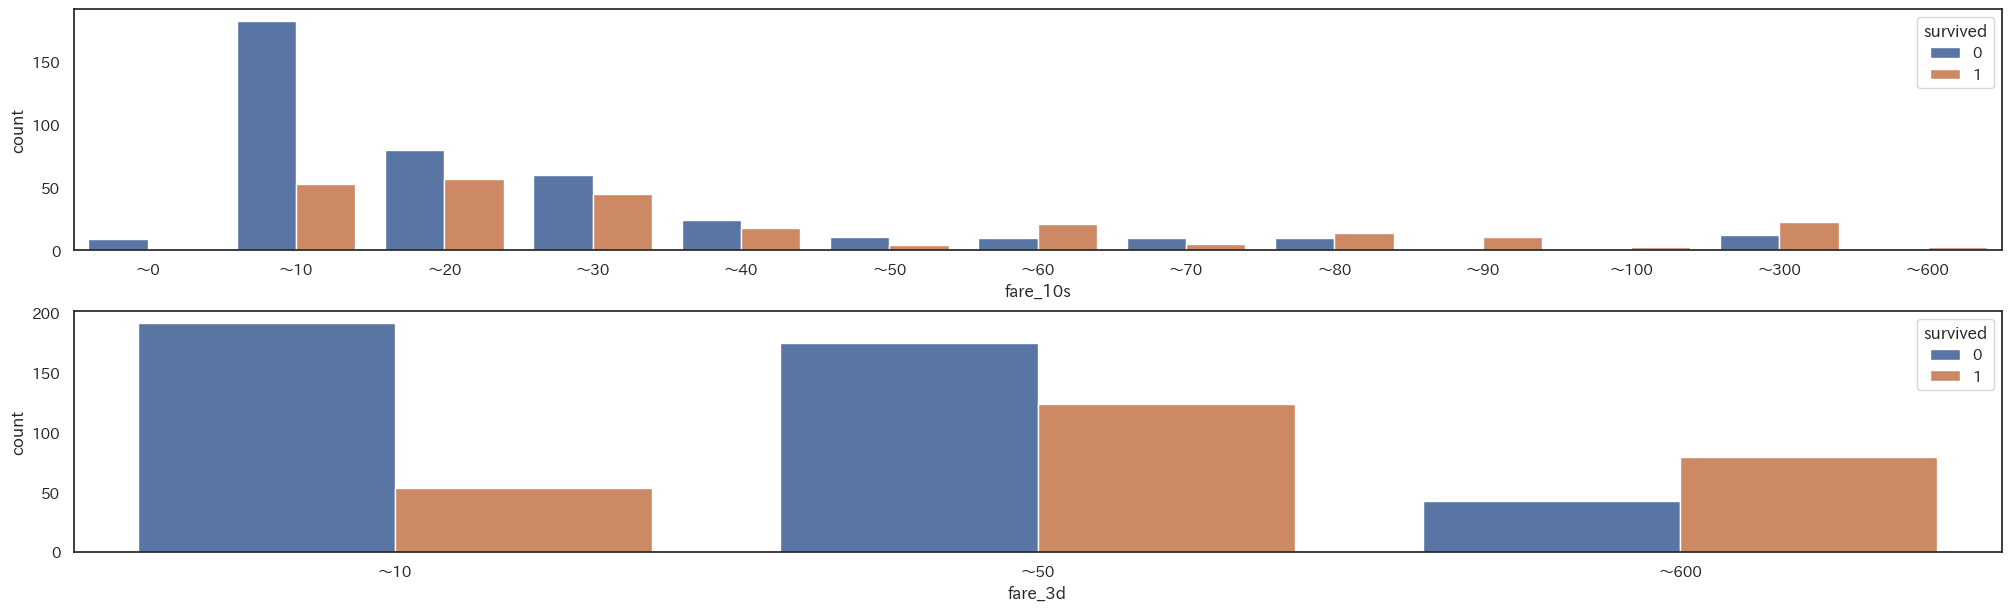

In [11]:
# fare

df['fare_10s'] = pd.cut(df['fare'], [i for i in range(-10, 101, 10)] + [300, 600],
                    labels=['～' + str(i) for i in range(0, 101, 10)] + ['～300', '～600'])
df['fare_3d'] = pd.cut(df['fare'], [-1, 10, 50, 600], labels=['～10', '～50', '～600'])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='fare_10s', hue='survived', ax=ax1)
sns.countplot(data=df, x='fare_3d', hue='survived', ax=ax2)
display(nin('fare_10s', data=df).T)
display(nin('fare_3d', data=df).T)

# 初期の避難では1等客が優先して救命ボートに乗せられたということなので、高い料金を払っている一部の乗客の生存率が総じて高い
# 低料金であることは3等客ということでもあるとおもう
# 3等客の生存率が24.5%なので、グラフは10ドル刻みだが近い数字になっている

248


fare,512.3292,263.0000,247.5208,227.5250,221.7792,211.5000,211.3375,164.8667,153.4625,151.5500,...,7.0500,6.9750,6.9500,6.8583,6.7500,6.4958,6.4375,6.2375,5.0000,0.0000
ID,3,3,1,2,1,1,3,1,2,3,...,5,2,1,1,1,1,1,1,1,10


Text(0.5, 1.0, 'うち、male')

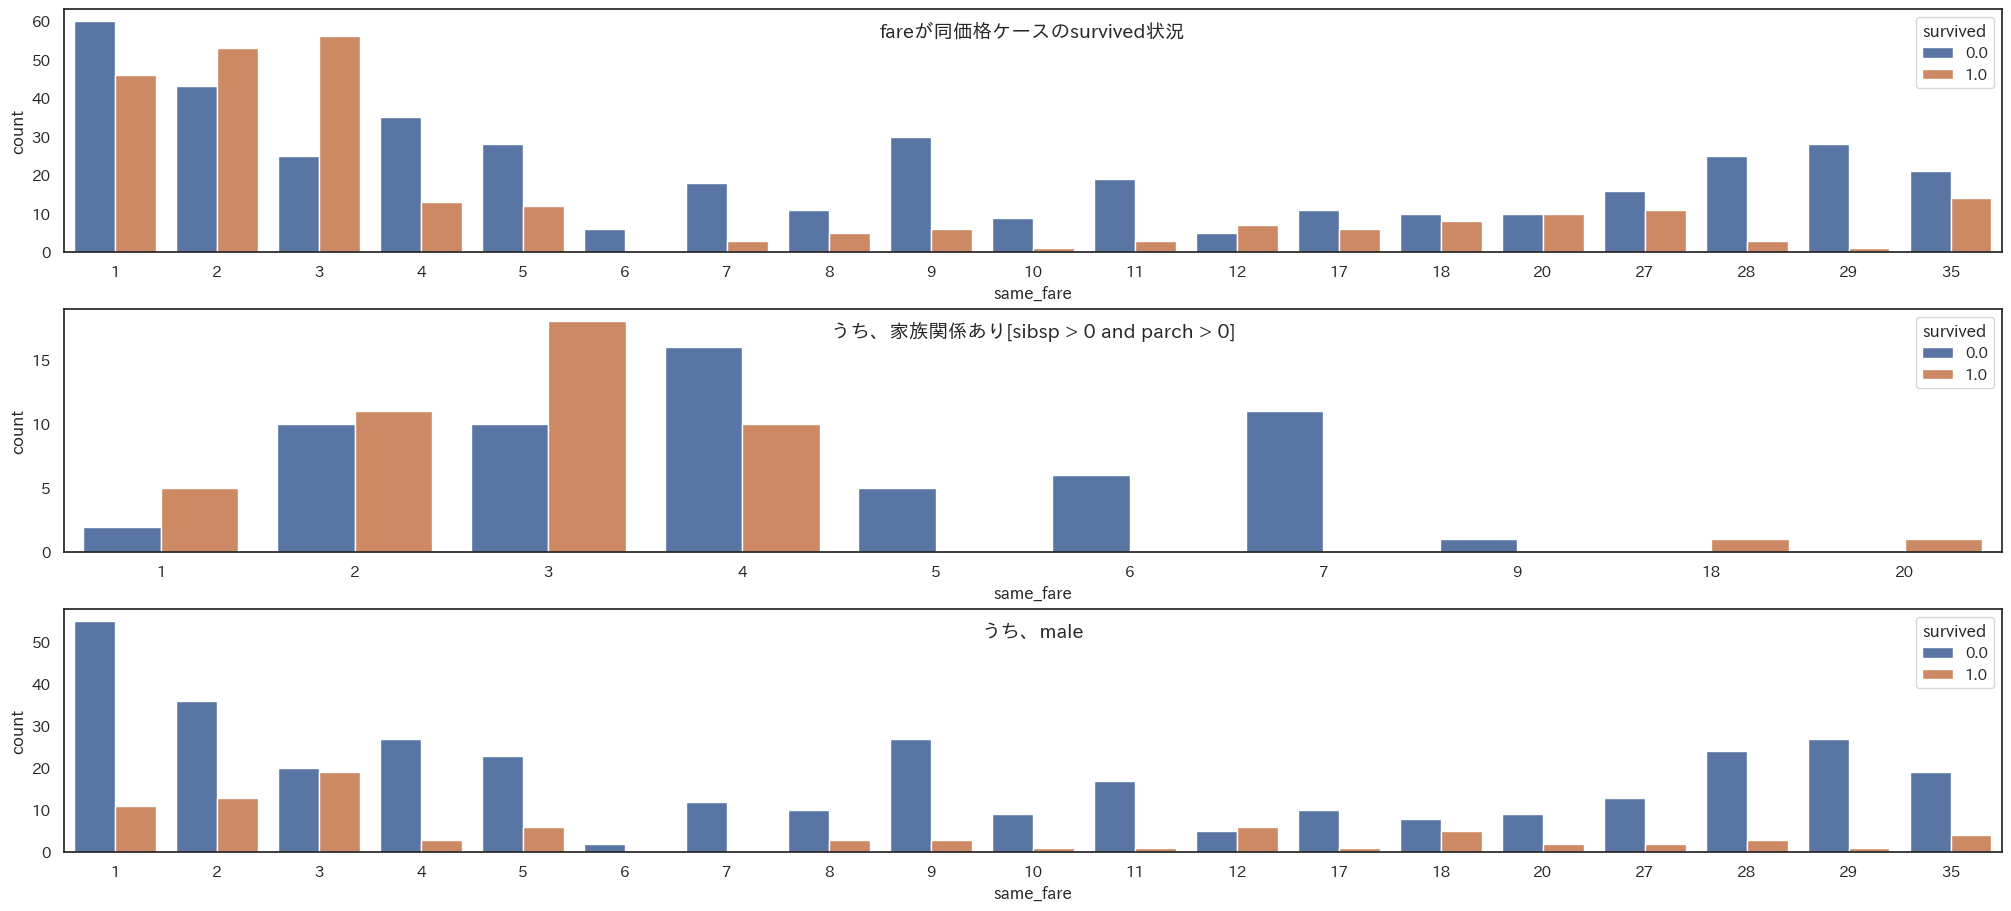

In [12]:
# fare2

# dfとdf_testを合せて処理
df_test['survived'] = np.nan
df_conv = pd.concat([df, df_test])
print(len(df_conv['fare'].unique()))
display(df.groupby('fare')[['ID']].count().sort_values('fare', ascending=False).T)

dic_same_fare = {}
for fare in nin('fare', data=df_conv)['total(b)'].index:
    dic_same_fare[fare] = nin('fare', data=df_conv)[['total(b)']].at[fare, 'total(b)']

df_conv['same_fare'] = df_conv['fare'].apply(lambda x: dic_same_fare[x])

# dfとdf_testに分割
df = df_conv[~df_conv['survived'].isnull()]
df_test = df_conv[df_conv['survived'].isnull()]
df_test = df_test.drop(columns='survived')

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 9), layout='constrained')
sns.countplot(data=df, x='same_fare', hue='survived', ax=ax1)
ax1.set_title('fareが同価格ケースのsurvived状況', fontsize=14, pad=-20)
sns.countplot(data=df[(df['sibsp'] > 0) & (df['parch'] > 0)], x='same_fare', hue='survived', ax=ax2)
ax2.set_title('うち、家族関係あり[sibsp > 0 and parch > 0]', fontsize=14, pad=-20)
sns.countplot(data=df[df['sex'] == 'male'], x='same_fare', hue='survived', ax=ax3)
ax3.set_title('うち、male', fontsize=14, pad=-20)


# 冒頭に記載の通り、データには横の関係性があるので、一旦、テストデータと合算して処理して改めて分割する
# fareには248種類もあり個別性が高いが、細かい数字まで同一のものがあり、同部屋か、同じ仕様の部屋の可能性が高い
# 3つ同じケースで明らかに生存率が高く2つも高いが4つ以上の生存率は高くない
# 家族関係がある乗客のsame_fareは少ない数値に集中しているが、全体からみるとひとつの側面でしかない
# 死亡率が高いmale（男性）も3の生存率は高い
# 同価格が3つや2つはおそらくは同部屋だが、3と4に明らかな差がある理由までは分からない


embarked,C,Q,S
survived(a),63.000000,24.0,169.000000
total(b),116.000000,60.0,490.000000
a/b,0.543103,0.4,0.344898


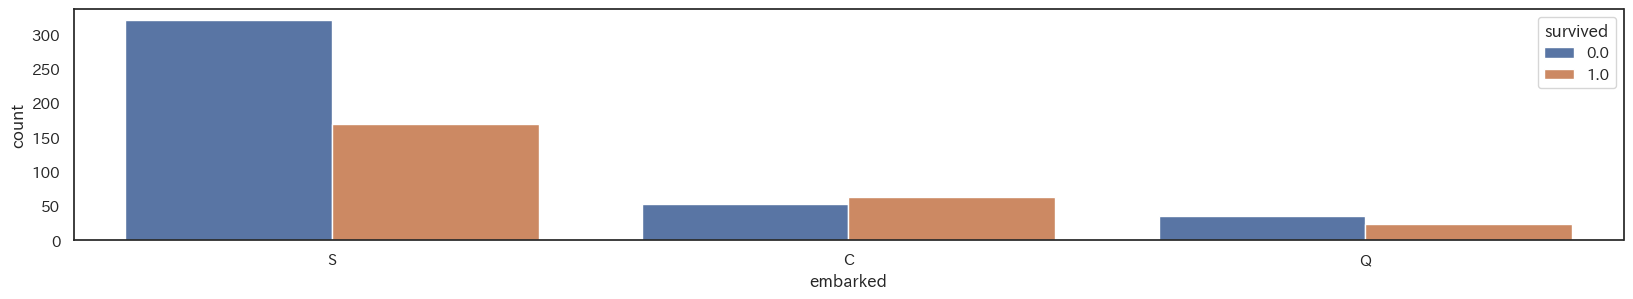

In [13]:
# embarked

fig, ax = plt.subplots(figsize=(20, 3))
sns.countplot(data=df, x='embarked', hue='survived', ax=ax)
display(nin('embarked', data=df).T)

# embarkedのCはCherbourg、QはQueenstown、SはSouthampton（EDAの冒頭の地図ご参照）
# Southamptonは、イギリス南部の年でタイタニック号の出発地、Cherbourgはフランス北部、ノルマンディ地方の港町、Queenstownはアイルランド南部の街で現在はCobh
# Southamptonの死亡率が高いのは3等客が多かったことに加え、多くの船員（9割死亡したとされる）が出発地のSouthamptonから乗り込んだことと関係が深いと考えられる
# 但し、船員と一般乗客の違いは良くわからない（fareが0の人は10人しかいないがうち9名が死亡している）
# Titanicの死亡者は1500人くらいと言われているので、サンプルは基本的に船員を除いたものということかもしれない

## 特徴量エンジニアリング（含む前処理）

In [14]:
# 欠損値補完1 embarked

display(df[df['embarked'].isnull()])
display(nin('pclass', 'sex').unstack())
display(nin('embarked'))
df.loc[df['embarked'].isnull(), 'embarked'] = 'C'

# 以上のEDAを踏まえてデータ加工を施し、機械学習モデルがより性能を発揮できるようにデータを整える作業が特徴量エンジニアリング
# EDAと完全に切り離すことはできないが、EDAで行う加工は必ずしも使う目的で行うわけではないので私はそこで区別している

# 該当２名の属性は生存者で、且つ、pclass 1 & femaleは生存率が95.8%もあるので一番生存率が高いCで補完する
# 一番数が多いSに入れるという考え方もあるがここでは寧ろノイズになると思う
# なお、df_testにembarkedの欠損値はない

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_5s,age_3d,fare_10s,fare_3d,same_fare
43,62,1.0,1,female,38.0,0,0,80.0,NaN,～40,15～,～80,～600,2
618,830,1.0,1,female,62.0,0,0,80.0,NaN,～65,15～,～80,～600,2


survived(a)      total(b)            a/b          
sex         female male   female male    female      male
pclass                                                   
1               68   32       71   92  0.957746  0.347826
2               53   15       58   80  0.913793  0.187500
3               53   37      102  265  0.519608  0.139623

,survived(a),total(b),a/b
embarked,,,
C,63,116,0.543103
Q,24,60,0.400000
S,169,490,0.344898


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 222
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         891 non-null    int64   
 1   survived   668 non-null    float64 
 2   pclass     891 non-null    int64   
 3   sex        891 non-null    object  
 4   age        714 non-null    float64 
 5   sibsp      891 non-null    int64   
 6   parch      891 non-null    int64   
 7   fare       891 non-null    float64 
 8   embarked   891 non-null    object  
 9   age_5s     535 non-null    category
 10  age_3d     535 non-null    category
 11  fare_10s   668 non-null    category
 12  fare_3d    668 non-null    category
 13  same_fare  891 non-null    int64   
dtypes: category(4), float64(3), int64(5), object(2)
memory usage: 81.6+ KB


,pclass,sex,sibsp,parch,fare,embarked
0,3,0,1,0,7.2500,0
1,3,1,0,0,7.9250,0
2,1,1,1,0,53.1000,0
3,3,0,0,0,8.0500,0
4,1,0,0,0,51.8625,0
...,...,...,...,...,...,...
218,3,0,0,0,7.8958,0
219,2,1,0,1,26.0000,0
220,2,0,0,0,10.5000,0
221,1,1,0,0,30.0000,0


0      22.0
1      26.0
2      35.0
3      35.0
4      54.0
       ... 
218    19.0
219    25.0
220    28.0
221    19.0
222    32.0
Name: age, Length: 714, dtype: float64

,pclass,sex,sibsp,parch,fare,embarked
12,2,0,0,0,13.0000,0
13,3,1,0,0,7.2250,2
20,3,0,0,0,7.2250,2
21,3,1,0,0,7.8792,1
22,3,0,0,0,7.8958,0
...,...,...,...,...,...,...
196,3,0,1,0,24.1500,1
199,3,0,0,0,7.7375,1
206,1,0,0,0,0.0000,0
212,3,0,0,0,8.0500,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 667
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         668 non-null    int64   
 1   survived   668 non-null    float64 
 2   pclass     668 non-null    int64   
 3   sex        668 non-null    object  
 4   age        668 non-null    float64 
 5   sibsp      668 non-null    int64   
 6   parch      668 non-null    int64   
 7   fare       668 non-null    float64 
 8   embarked   668 non-null    object  
 9   age_5s     535 non-null    category
 10  age_3d     535 non-null    category
 11  fare_10s   668 non-null    category
 12  fare_3d    668 non-null    category
 13  same_fare  668 non-null    int64   
dtypes: category(4), float64(3), int64(5), object(2)
memory usage: 61.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 222
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ID         223 non-null    int64   
 1   pclass     223 non-null    int64   
 2   sex        223 non-null    object  
 3   age        223 non-null    float64 
 4   sibsp      223 non-null    int64   
 5   parch      223 non-null    int64   
 6   fare       223 non-null    float64 
 7   embarked   223 non-null    object  
 8   age_5s     0 non-null      category
 9   age_3d     0 non-null      category
 10  fare_10s   0 non-null      category
 11  fare_3d    0 non-null      category
 12  same_fare  223 non-null    int64   
dtypes: category(4), float64(2), int64(5), object(2)
memory usage: 19.9+ KB


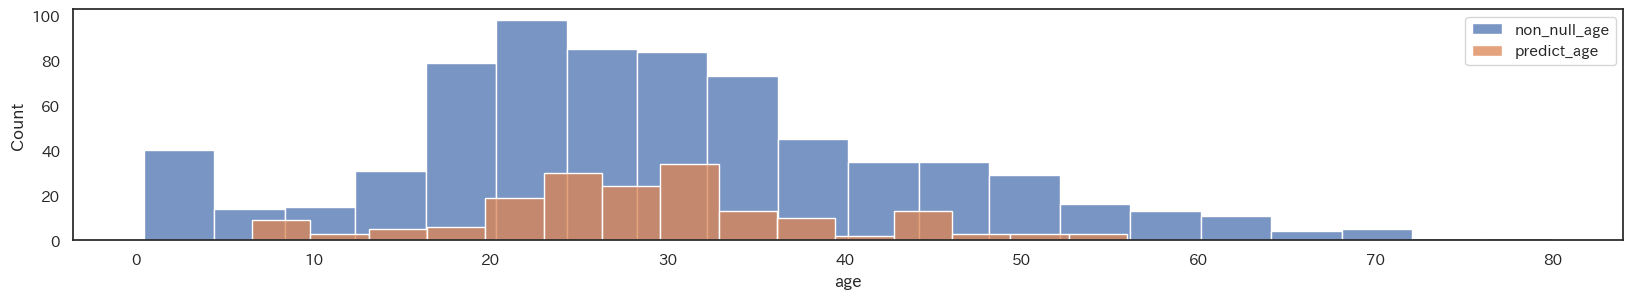

In [15]:
# 欠損値補完2 age

# dfとdf_testを合せて処理
df_test['survived'] = np.nan
df_conv = pd.concat([df, df_test])
df_conv.info()

# 前処理（trainとtestに分割）
df_age_train = df_conv[~df_conv['age'].isnull()][['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'age']]
df_age_test = df_conv[df_conv['age'].isnull()][['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked']]

# 質的変数をエンコーディング
df_age_train['sex'] = df_age_train['sex'].replace(['male', 'female'], [0, 1])
df_age_test['sex'] = df_age_test['sex'].replace(['male', 'female'], [0, 1])
df_age_train['embarked'] = df_age_train['embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
df_age_test['embarked'] = df_age_test['embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])

# 機械学習にfitさせる形式に変換
y_train = df_age_train['age']
X_train = df_age_train.drop(columns='age')
display(X_train)
display(y_train)
display(df_age_test)

# RFGモデルで予測
RFG_model = ensemble.RandomForestRegressor()
RFG_model = RFG_model.fit(X_train, y_train)
RFG_pred = RFG_model.predict(df_age_test)

# 予測結果を欠損部分に補完
df_conv.loc[df_conv['age'].isnull(), 'age'] = RFG_pred

# 改めてdfとdf_testに分割
df = df_conv[~df_conv['survived'].isnull()]
df_test = df_conv[df_conv['survived'].isnull()]
df_test = df_test.drop(columns='survived')

display(df.info())
df_test.info()

fig, ax = plt.subplots(figsize=(20,3))
sns.histplot(y_train, label='non_null_age', ax=ax)
sns.histplot(RFG_pred, label='predict_age', ax=ax)
ax.legend()

# 全体のデータ数に対して数も多くその補完方法の影響は小さくないと思われる
# よって、他の特徴量から回帰モデル（ここではランダムフォレスト）で予測を行って補完する
# dfとdf_testがあるので合算して処理し、再び分割している
# やり方はワンパターンなので意外に簡単で普段使い可

family,0,1,2,3,4,5,6,7,10
survived(a),125.000000,67.000000,42.00,16.000000,1.000000,3.00,4.000000,NaN,NaN
total(b),404.000000,118.000000,75.00,24.000000,12.000000,12.00,11.000000,5.0,7.0
a/b,0.309406,0.567797,0.56,0.666667,0.083333,0.25,0.363636,NaN,NaN


family_g,0,1
survived(a),133.0000,125.000000
total(b),451.0000,217.000000
a/b,0.2949,0.576037


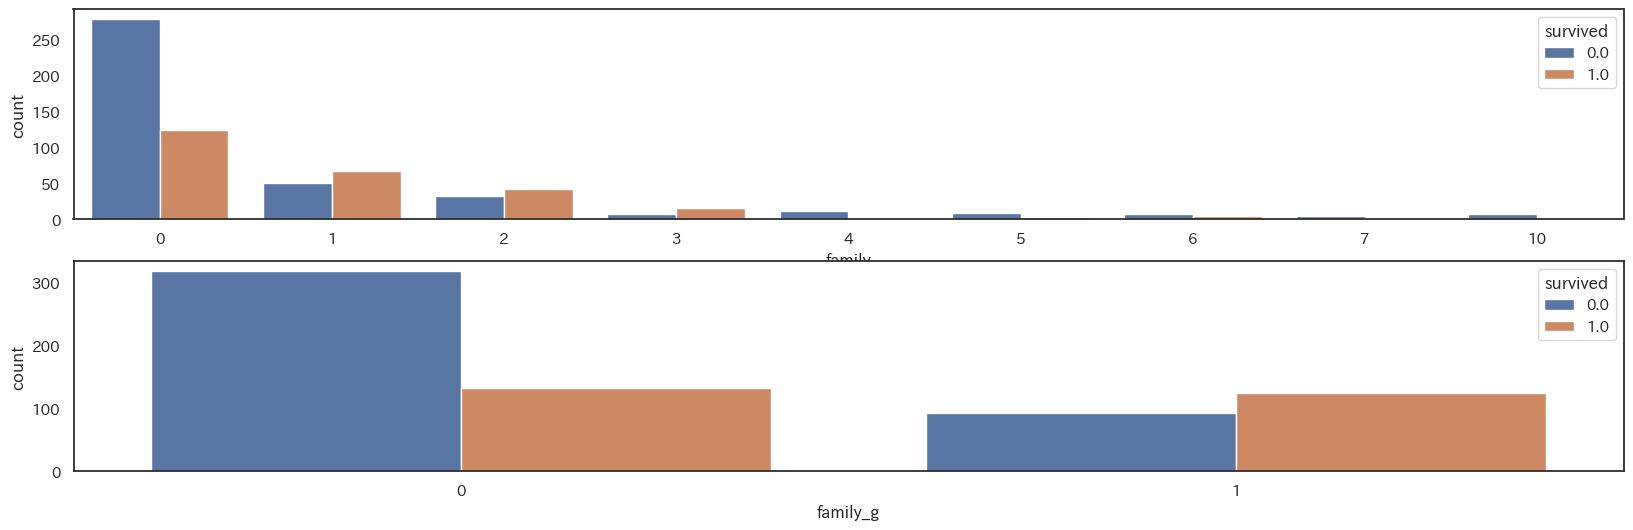

In [16]:
# 特徴量 family, family_g

df['family'] = df.apply(lambda x: x['sibsp'] + x['parch'], axis=1)
df_test['family'] = df_test.apply(lambda x: x['sibsp'] + x['parch'], axis=1)

df['family_g'] = df['family'].apply(lambda x: 1 if (x >= 1 and x <= 3) else 0)
df_test['family_g'] = df_test['family'].apply(lambda x: 1 if (x >= 1 and x <= 3) else 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.countplot(data=df, x='family', hue='survived', ax=ax1)
sns.countplot(data=df, x='family_g', hue='survived', ax=ax2)

display(nin('family', data=df).T)
display(nin('family_g', data=df).T)

# sibspとparchを合算してfamilyを作成
# 自身と親族合せて2～4名のグループで生存率が高い ⇒ family_gとして使う


In [17]:
# 特徴量　age_2d

df['age_3d'] = pd.cut(df['age'], [0, 5, 15, 80], labels=[2, 1, 0]).astype(int)
df_test['age_3d'] = pd.cut(df_test['age'], [0, 5, 15, 80], labels=[2, 1, 0]).astype(int)

# ageの補完を反映
# category変数のままでは使えないので「順序尺度」の整数に変換する

In [18]:
# 特徴量 fare_3d

df['fare_3d'] = pd.cut(df['fare'], [-10, 10, 50, 600], labels=[0, 1, 2]).astype(int)
df_test['fare_3d'] = pd.cut(df_test['fare'], [-10, 10, 50, 600], labels=[0, 1, 2]).astype(int)

# fare_3dも同様に「順序尺度」変換


same_fare,1,2,3,4,5,7,8,9,10,11,12,17,18,20,27,28,29,35,6
survived(a),46.000000,53.000000,56.000000,13.000000,12.0,3.000000,5.0000,6.000000,1.0,3.000000,7.000000,6.000000,8.000000,10.0,11.000000,3.000000,1.000000,14.0,0.0
total(b),106.000000,96.000000,81.000000,48.000000,40.0,21.000000,16.0000,36.000000,10.0,22.000000,12.000000,17.000000,18.000000,20.0,27.000000,28.000000,29.000000,35.0,6.0
a/b,0.433962,0.552083,0.691358,0.270833,0.3,0.142857,0.3125,0.166667,0.1,0.136364,0.583333,0.352941,0.444444,0.5,0.407407,0.107143,0.034483,0.4,0.0


,survived(a),total(b),a/b
same_fare_3d,,,
0,149,491,0.303462
1,53,96,0.552083
2,56,81,0.691358


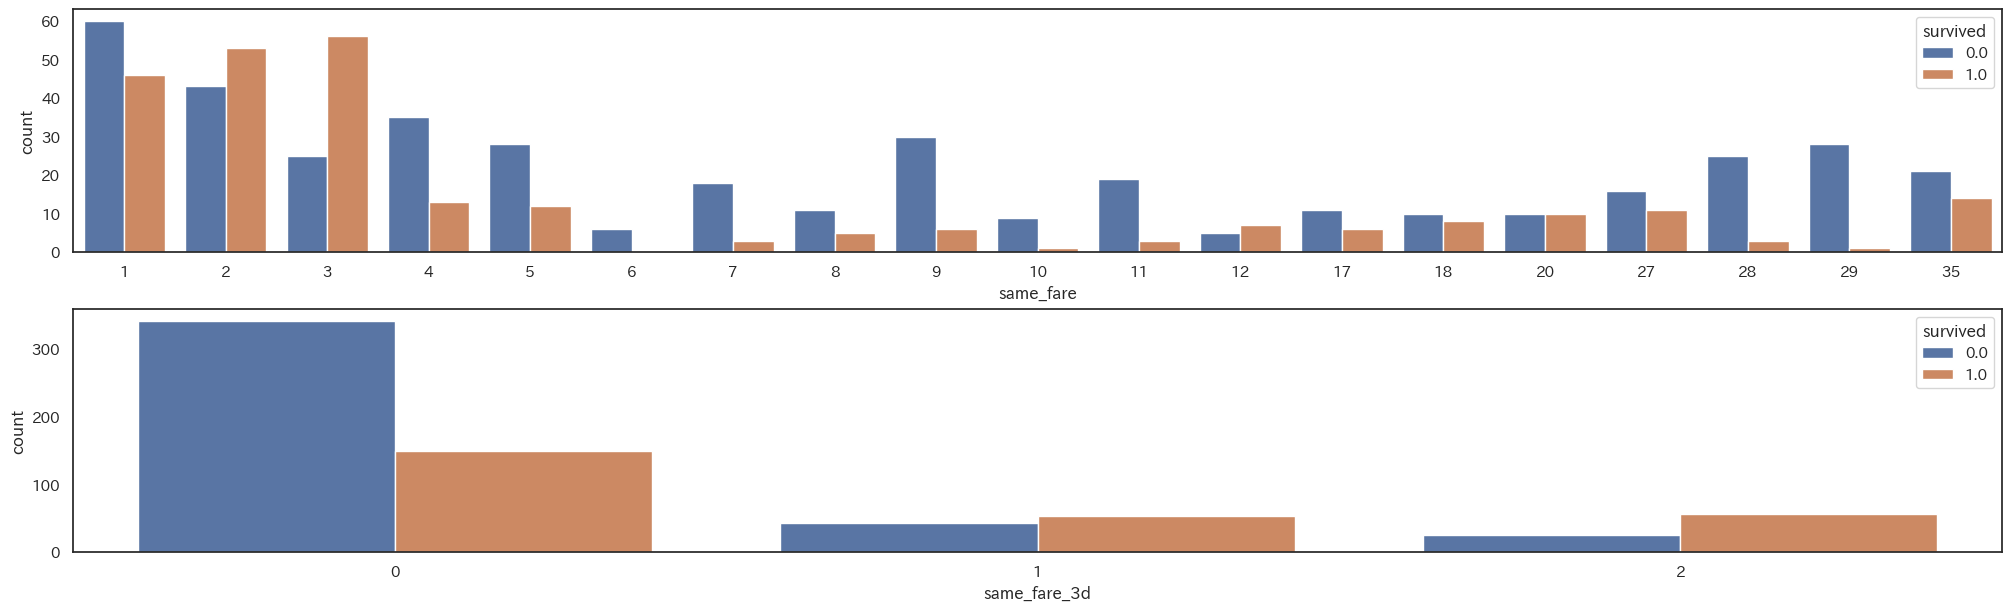

In [19]:
# 特徴量 same_fare_3d

df['same_fare_3d'] = df['same_fare'].apply(lambda x: 2 if x == 3 else 1 if x == 2 else 0)
df_test['same_fare_3d'] = df_test['same_fare'].apply(lambda x: 2 if x == 3 else 1 if x == 2 else 0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.countplot(data=df, x='same_fare', hue='survived', ax=ax1)
sns.countplot(data=df, x='same_fare_3d', hue='survived', ax=ax2)

display(nin('same_fare', data=df).T.fillna(0))
display(nin('same_fare_3d', data=df))

# 数が多いところにもところどころ生存率の高い塊があるが特定するのは難しい
# 意味的に確実性の高い2と3、およびその他に分類した

### 組み合わせ特徴量

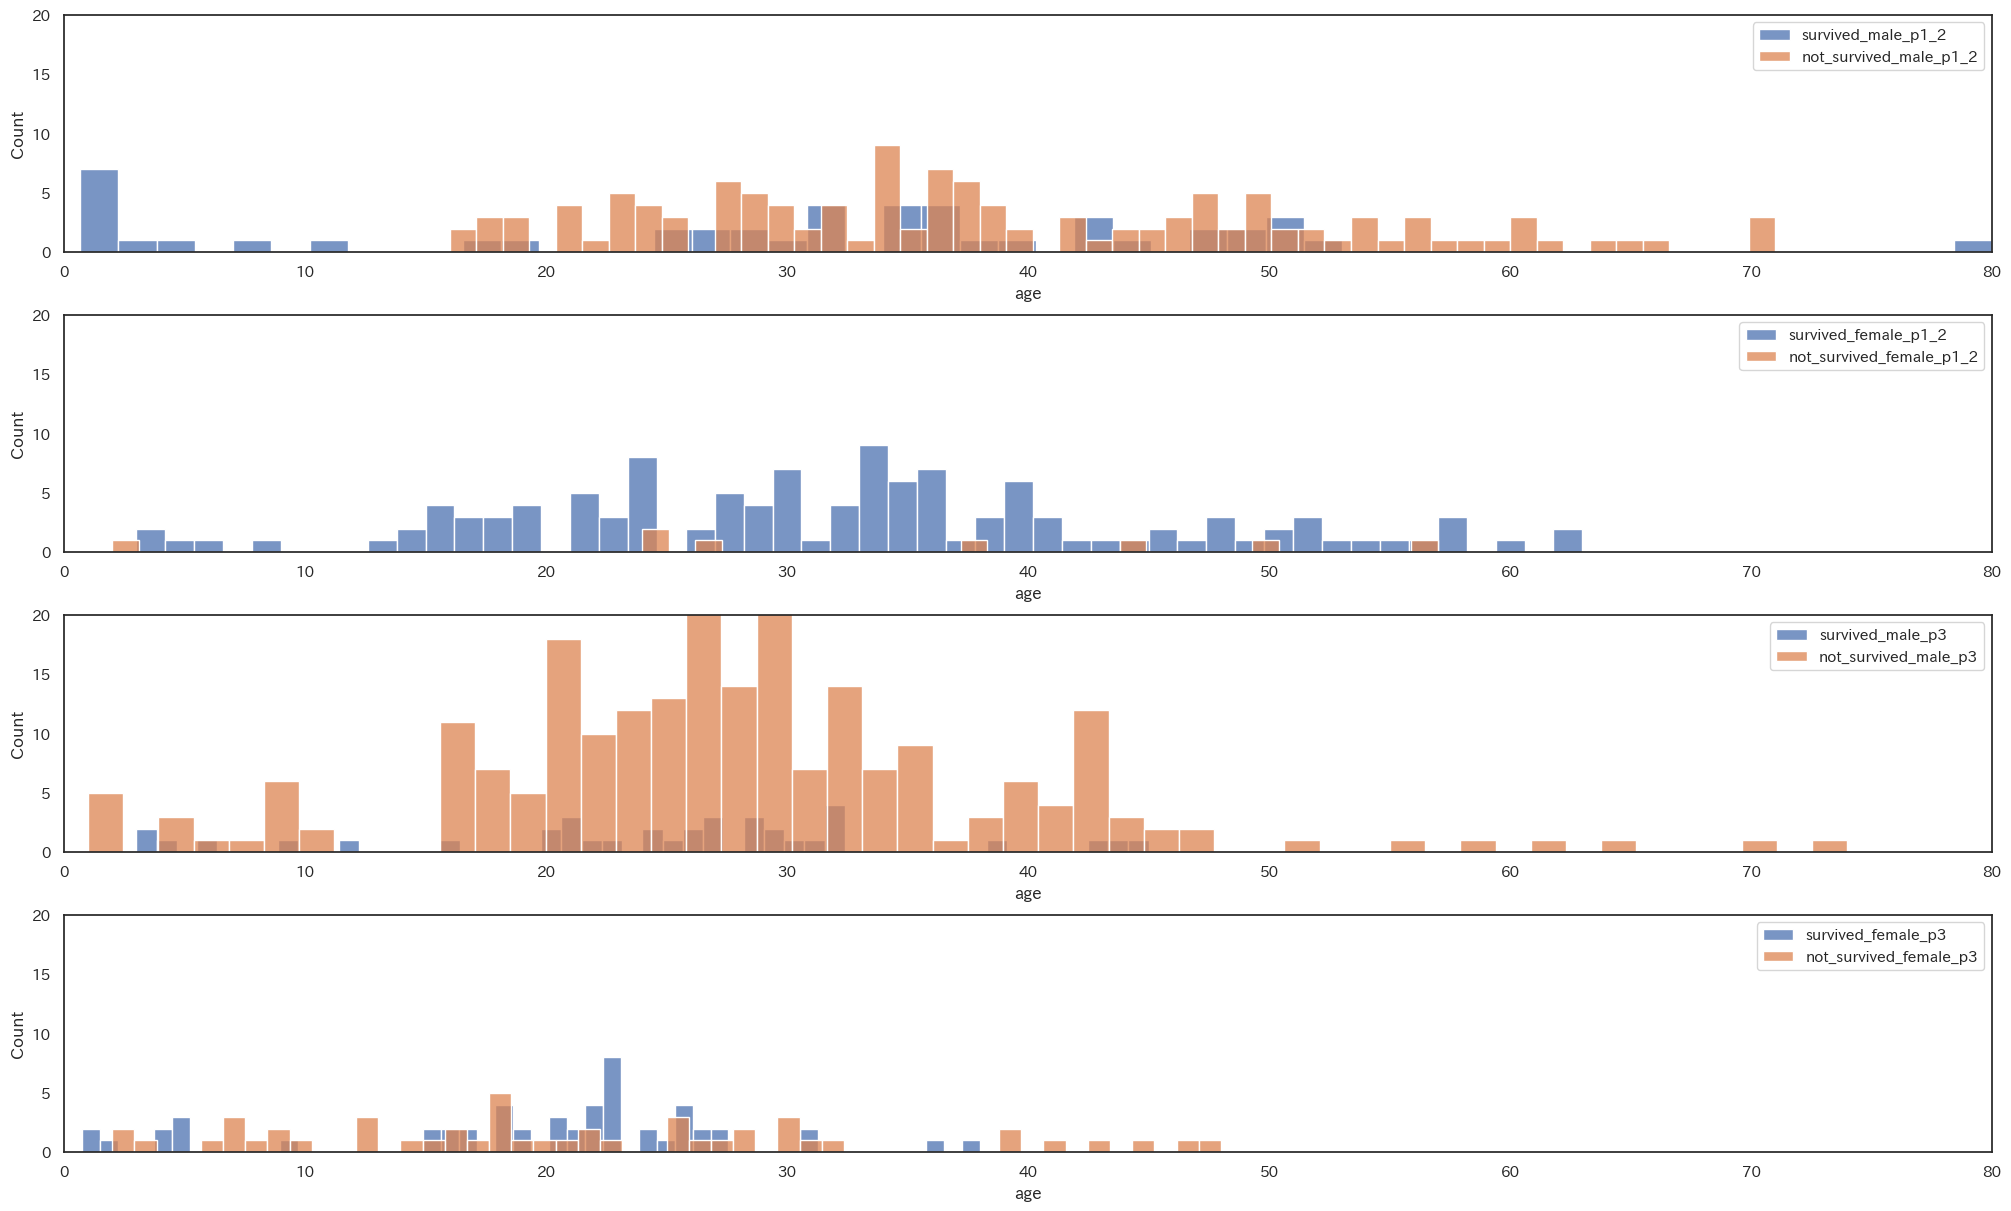

In [20]:
# sex,pclassの関係を可視化

df_survived_male_p1_2 = df.loc[(df['survived']==1)&(df['sex']=='male')&(df['pclass']!=3), :]
df_not_survived_male_p1_2 = df.loc[(df['survived']==0)&(df['sex']=='male')&(df['pclass']!=3), :]
df_survived_female_p1_2 = df.loc[(df['survived']==1)&(df['sex']=='female')&(df['pclass']!=3), :]
df_not_survived_female_p1_2 = df.loc[(df['survived']==0)&(df['sex']=='female')&(df['pclass']!=3), :]

df_survived_male_p3 = df.loc[(df['survived']==1)&(df['sex']=='male')&(df['pclass']==3), :]
df_not_survived_male_p3 = df.loc[(df['survived']==0)&(df['sex']=='male')&(df['pclass']==3), :]
df_survived_female_p3 = df.loc[(df['survived']==1)&(df['sex']=='female')&(df['pclass']==3), :]
df_not_survived_female_p3 = df.loc[(df['survived']==0)&(df['sex']=='female')&(df['pclass']==3), :]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12), layout='constrained')
sns.histplot(df_survived_male_p1_2['age'], label='survived_male_p1_2', bins=50, ax=ax1)
sns.histplot(df_not_survived_male_p1_2['age'], label='not_survived_male_p1_2', bins=50, ax=ax1)
sns.histplot(df_survived_female_p1_2['age'], label='survived_female_p1_2', bins=50, ax=ax2)
sns.histplot(df_not_survived_female_p1_2['age'], label='not_survived_female_p1_2', bins=50, ax=ax2)

sns.histplot(df_survived_male_p3['age'], label='survived_male_p3', bins=50, ax=ax3)
sns.histplot(df_not_survived_male_p3['age'], label='not_survived_male_p3', bins=50, ax=ax3)
sns.histplot(df_survived_female_p3['age'], label='survived_female_p3', bins=50, ax=ax4)
sns.histplot(df_not_survived_female_p3['age'], label='not_survived_female_p3', bins=50, ax=ax4)


ax1.set_xlim(0,80)
ax2.set_xlim(0,80)
ax3.set_xlim(0,80)
ax4.set_xlim(0,80)

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax3.set_ylim(0,20)
ax4.set_ylim(0,20)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# 意味的にも生存率的にも特徴量として際立っているため組み合わせの特徴量を検討


In [21]:
# 特徴量 alive
df_temp = nin('pclass', 'sex', 'age_3d', data=df).T
display(df_temp.T[df_temp.T['a/b']>=0.9].T)

df['alive'] = df.apply(lambda x: 1 if ((x['pclass']!=3)
                                     & (x['sex']=='female'))
                                    | ((x['pclass']!=3)
                                     & (x['sex']=='male')
                                     & (x['age_3d']!=0))
                                   else 0, axis=1)

df_test['alive'] = df_test.apply(lambda x: 1 if ((x['pclass']!=3)
                                       & (x['sex']=='female'))
                                    | ((x['pclass']!=3)
                                       & (x['sex']=='male')
                                       & (x['age_3d']!=0))
                                    else 0, axis=1)

df[df['alive']==1]

# pclassや性別、年齢層には意味的に有意な差があるため、その組み合わせを特徴量として追加する
# やり過ぎると過学習になる（極端にはsurvived==1のカテゴリを全部集める例）が、相関の高い特徴量を作って加えることが有効な場合が多い
# カテゴリはできるだけ大まかなもので、且つ、特徴が際立つことが大事
# ここでは生存率9割以上の確実なところを3つの特徴量に限定して纏めている


pclass               1                         2                    
sex             female      male          female           male     
age_3d               0    1    1    2          0    1    2    1    2
survived(a)  66.000000  2.0  1.0  2.0  46.000000  4.0  3.0  1.0  7.0
total(b)     68.000000  2.0  1.0  2.0  51.000000  4.0  3.0  1.0  7.0
a/b           0.970588  1.0  1.0  1.0   0.901961  1.0  1.0  1.0  1.0

,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_5s,age_3d,fare_10s,fare_3d,same_fare,family,family_g,same_fare_3d,alive
2,4,1.0,1,female,35.0,1,0,53.1000,S,～35,0,～60,2,5,1,1,0,1
6,10,1.0,2,female,14.0,1,0,30.0708,C,～15,1,～40,1,1,1,1,0,1
7,12,1.0,1,female,58.0,0,0,26.5500,S,～60,0,～30,1,12,0,0,0,1
10,16,1.0,2,female,55.0,0,0,16.0000,S,～55,0,～20,1,1,0,0,0,1
28,42,0.0,2,female,27.0,1,0,21.0000,S,～30,0,～30,1,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,866,1.0,2,female,42.0,0,0,13.0000,S,～45,0,～20,1,35,0,0,0,1
649,867,1.0,2,female,27.0,1,0,13.8583,C,～30,0,～20,1,1,1,1,0,1
654,872,1.0,1,female,47.0,1,1,52.5542,S,～50,0,～60,2,3,2,1,2,1
657,875,1.0,2,female,28.0,1,0,24.0000,C,～30,0,～30,1,1,1,1,0,1


In [22]:
# 特徴量 dead

df_temp = nin('pclass', 'sex', 'age_3d', data=df).T
display(df_temp.T[df_temp.T['a/b']<=0.15].T)

df['dead'] = df.apply(lambda x: 1 if ((x['pclass']!=1)
                                    & (x['sex']=='male')
                                    & (x['age_3d']==0))
                                  else 0, axis=1)

df_test['dead'] = df_test.apply(lambda x: 1 if ((x['pclass']!=1)
                                              & (x['sex']=='male')
                                              & (x['age_3d']==0))
                                            else 0, axis=1)

df[df['dead']==1]

# aliveと平仄を合せて1割以内でも良いが、12.9%に大きな塊があるので閾値を少し下げた
# シンプルな例なので問題ないと思う

pclass,2,3
sex,male,male
age_3d,0,0
survived(a),7.000000,31.000000
total(b),72.000000,241.000000
a/b,0.097222,0.128631


,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_5s,age_3d,fare_10s,fare_3d,same_fare,family,family_g,same_fare_3d,alive,dead
0,1,0.0,3,male,22.000000,1,0,7.2500,S,～25,0,～10,0,11,1,1,0,0,1
3,5,0.0,3,male,35.000000,0,0,8.0500,S,～35,0,～10,0,28,0,0,0,0,1
8,13,0.0,3,male,20.000000,0,0,8.0500,S,～20,0,～10,0,28,0,0,0,0,1
9,14,0.0,3,male,39.000000,1,5,31.2750,S,～40,0,～40,1,6,6,0,0,0,1
12,18,1.0,2,male,31.984025,0,0,13.0000,S,NaN,0,～20,1,35,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,877,0.0,3,male,20.000000,0,0,9.8458,S,～20,0,～10,0,1,0,0,0,0,1
659,879,0.0,3,male,27.218669,0,0,7.8958,S,NaN,0,～10,0,29,0,0,0,0,1
661,882,0.0,3,male,33.000000,0,0,7.8958,S,～35,0,～10,0,29,0,0,0,0,1
663,885,0.0,3,male,25.000000,0,0,7.0500,S,～25,0,～10,0,5,0,0,0,0,1


### エンコーディング

In [23]:
# エンコーディング

df['sex'] = df['sex'].replace(['male', 'female'], [0, 1])
df_test['sex'] = df_test['sex'].replace(['male', 'female'], [0, 1])

df['embarked'] = df['embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])
df_test['embarked'] = df_test['embarked'].replace(['S', 'Q', 'C'], [0, 1, 2])

df['pclass'] = df['pclass'].replace([3, 2, 1], [0, 1, 2])
df_test['pclass'] = df_test['pclass'].replace([3, 2, 1], [0, 1, 2])

# 0，1のものに順序はないらしいが、3つ以上あるものは「順序尺度」を意識してエンコードする

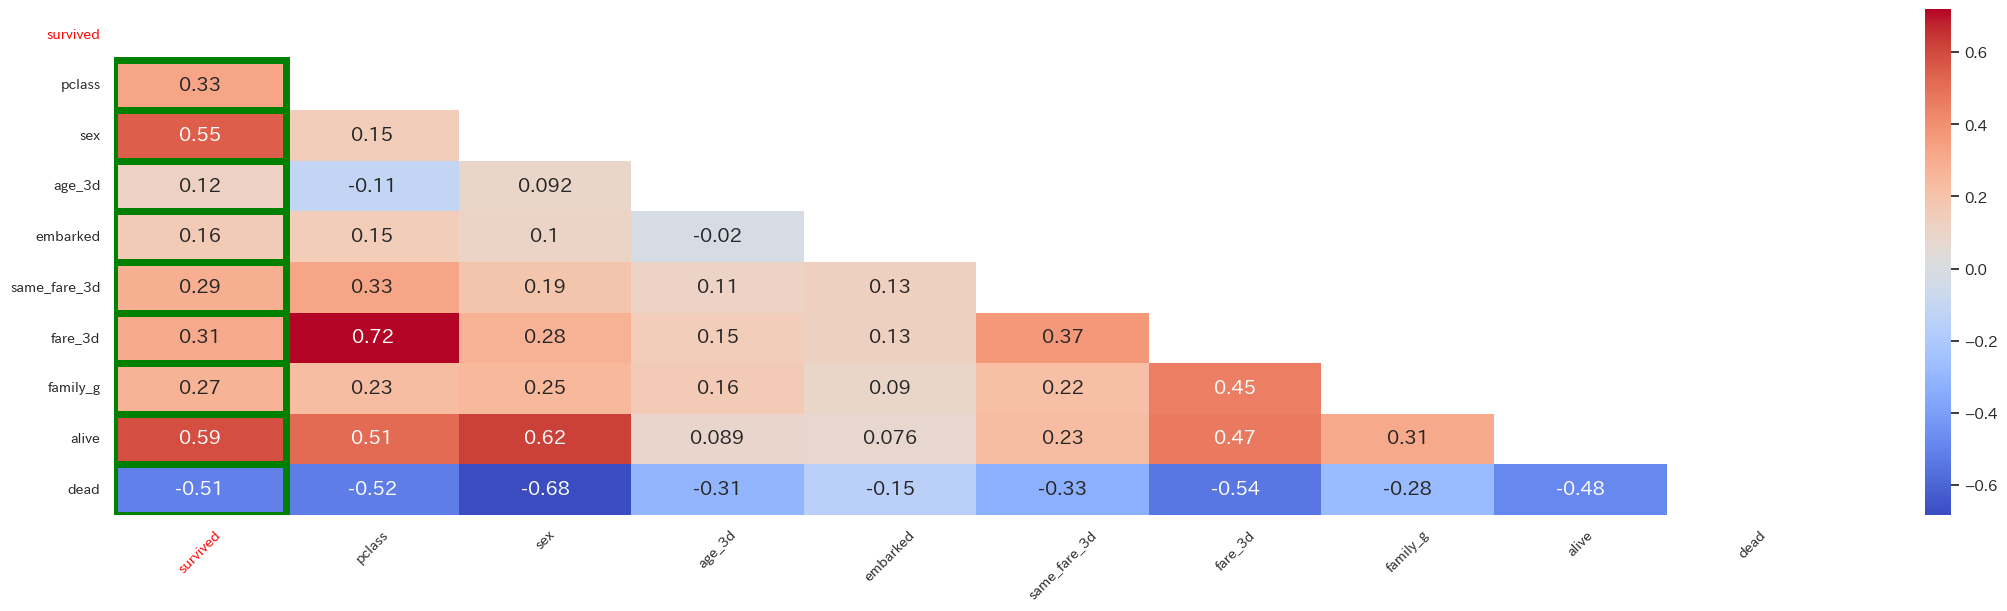

In [24]:

# ヒートマップ,相関係数
corr = df[['survived', 'pclass', 'sex', 'age_3d', 'embarked', 'same_fare_3d', 'fare_3d',
           'family_g', 'alive', 'dead']].corr()
fig, ax = plt.subplots(figsize=(20, 6), layout='constrained')
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={'size':14})
ax.tick_params(axis='x', labelsize=10, rotation=45)
ax.tick_params(axis='y', labelsize=10)

# 目的変数の枠線の追加
index = list(corr.columns).index('survived')
for i in range(len(corr.columns)):
    if i > index:
        plt.gca().add_patch(plt.Rectangle((index, i), 1, 1,
                                          fill=False, edgecolor='green', lw=5))
    elif i < index:
        plt.gca().add_patch(plt.Rectangle((i, index), 1, 1,
                                          fill=False, edgecolor='green', lw=5))

# 目的変数の強調
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == 'survived':
        label.set_color('red')
        label.set_fontweight('bold')
for i, label in enumerate(ax.get_yticklabels()):
    if label.get_text() == 'survived':
        label.set_color('red')
        label.set_fontweight('bold')
plt.show()

# 一旦は使わない特徴量も含めて確認するが、ここでは使うものだけで表示している
# heatmapの数字については、2要素間の相関係数なのでこの数字が必ずしもスコアに繋がる感じもしない
# 多重共線性とノイズのチェックを行う上で参考にしているが、スコアはしばしば見た目通りではないことに注意


In [25]:
features = ['survived', 'sex', 'pclass', 'age', 'embarked', 'family_g', 'alive', 'dead' , 'same_fare_3d', 'fare_3d']

# 機械学習にかける特徴量をこの変数で調整する
# シンプルなものから順次加えて、各モデルに対する影響を見ていく（木系と回帰系で挙動が異なる印象あり）
# 今回は単純化した特徴量をたくさん与える方法で安定化を図った形
# なお、これまで特徴量削除の手順を真似ていたが、削除してしまうと戻ってEDAをやるのに不都合なのでこの方法に変えた

In [26]:
df_train, df_val = train_test_split(df[features], test_size=0.3, random_state=42)

# データ数が少ない⇒訓練データを多めに確保すると、今度はバリデーションデータのブレが大きくなる
# バランスが難しいが、バリデーションの精度を上げたかったので通常0.2のところtest_sizeは0.3にした
# random_stateを指定して固定することで上記シミュレーションの影響を確認できる

In [27]:
# 機械学習モデルにfitさせる形式に変換

X_train = df_train.drop(columns='survived')
y_train = df_train['survived']
X_test = df_val.drop(columns='survived')
y_test = df_val['survived']

RandomForestRegressor(random_state=42) 
   auc      :  0.9050062840385422
DecisionTreeClassifier(random_state=42) 
   auc      :  0.8114264767490573                       
   accuracy :  0.8159203980099502
RandomForestClassifier(random_state=42) 
   auc      :  0.8324780058651027                       
   accuracy :  0.835820895522388
LogisticRegression() 
   auc      :  0.8443653121072476                       
   accuracy :  0.8656716417910447


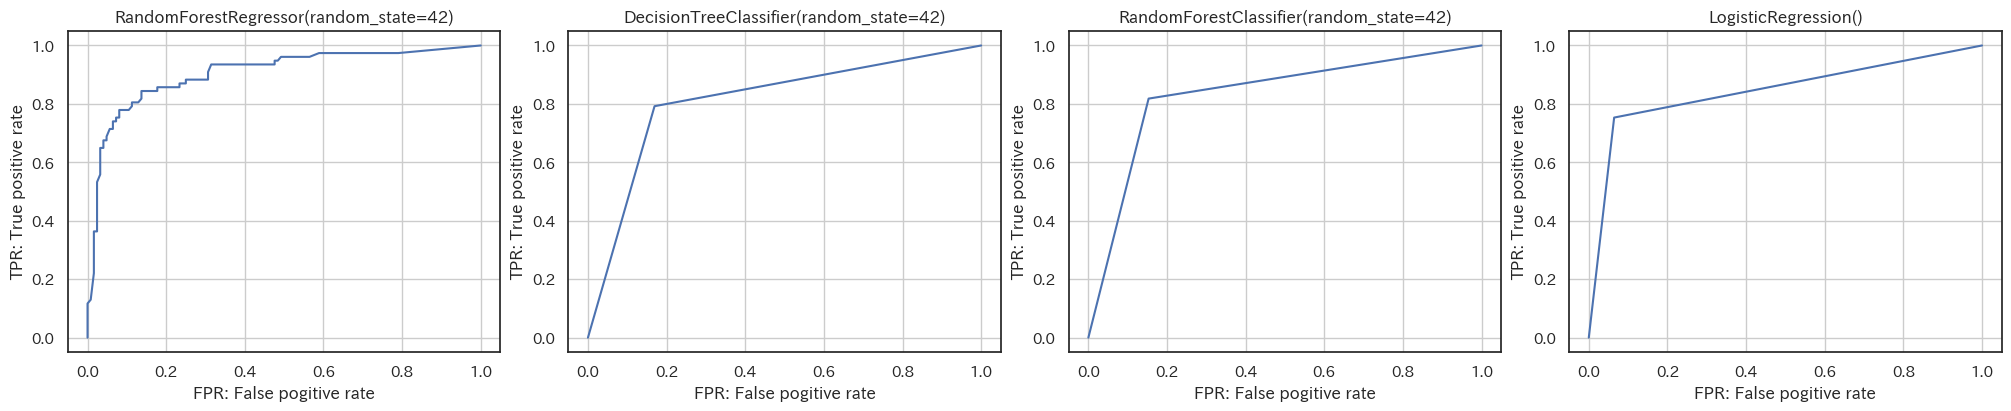

In [28]:
# 複数の学習モデルで検証

models = [ensemble.RandomForestRegressor(random_state=42),
         tree.DecisionTreeClassifier(random_state=42),
         ensemble.RandomForestClassifier(random_state=42),
         LR()]

fig, ax = plt.subplots(1, 4, figsize=(20, 4), layout='constrained')
for i, model in enumerate(models):
    name = model
    name = name.fit(X_train, y_train)
    pred = name.predict(X_test)
    score1 = roc_auc_score(y_test, pred)
    if i == 0:
        print(f'{name} \n   auc      :  {score1}')
    else:
        score2 = accuracy_score(y_test, pred)
        print(f'{name} \n   auc      :  {score1}\
                       \n   accuracy :  {score2}')
    roc = roc_curve(y_test, pred)
    ax[i].plot(roc[0], roc[1])
    ax[i].set_xlabel('FPR: False pogitive rate')
    ax[i].set_ylabel('TPR: True positive rate')
    ax[i].grid()
    ax[i].set_title(model, fontsize=12)

# 比較のために、RFGモデルも加えて連続値との違いを確認した
# また、accuracyとaucの比較も行った
# グラフを見れば分かるが、aucでは確率分布の連続値の方が丸めたものより高くなる
# また、ここではacurracyの方がaucより高めに出る。（計算方法の違いに拠る）